# Introduction
L'objectif est de créer un classifieur binaire qui trie des images en deux catégories : les photos et les non-photos.  
Ce document présente l'exploration et le traitement des images afin de présenter les données au modèle sous la meilleure forme.

# Pre processing
Ce notebook présente l'exploration de nos données ainsi que les traitements de nettoyage afin de fournir nos données au format optimal pour notre classifieur.   
Le notebook télécharge les données puis effectue les transformations. Il suffit d'éxécuter l'intégralité des cellules dans l'ordre pour terminer le pré-processing.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import requests
import zipfile
from PIL import Image
from tqdm.notebook import tqdm
import shutil
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import random
import math

## 0. Variables
Définition des paramètres du pré-processing.

In [2]:
random.seed(123)

download_url = "https://viacesifr-my.sharepoint.com/:u:/g/personal/armand_debesse_viacesi_fr/Efhh8ZEjkt9Iqbeb_Tx11rUBL5FXsOQISqiJUxzMOEZx0Q?download=1"

sources_directory = "./OneDrive_2022-09-22/"
sources_categories = ['Photo', 'Painting', 'Schematics', 'Sketch', 'Text']

process_directory = "./processed_data/"

image_valid_extensions = [".png", ".jpg", ".jpeg"]
image_target_size = (300, 300)

## 1. Chargement des données dans un dataframe
La première étape consiste à charger nos données brut afin de les explorer.

### 1.1. Téléchargement des données

Nous allons télécharger les données directement à la source dans un premier temps et mettre une condition lorsque le dataset est déjà présent.

In [ ]:
def download_and_unzip(url, filename="downloaded.zip"):
    """
    Downloads a zip file from the given URL and unzips it in the current directory.

    Parameters:
    - url: The URL of the zip file to download.
    - filename: The name to give to the downloaded file (optional).

    Returns:
    - None
    """
    chunk_size = 8*1024
    
    response = requests.get(url, stream=True)
    total_size = int(response.headers["Content-Length"])
    with open(filename, 'wb') as file:
        with tqdm(desc="Downloading dataset", total=total_size, unit_scale=True, unit="B", unit_divisor=1024) as t:
            for chunk in response.iter_content(chunk_size=chunk_size):
                file.write(chunk)
                t.update(len(chunk))
                
    print("Extracting...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()
    print("Extracted")

    print("Cleaning...")
    os.remove(filename)
    print("Cleaned")

In [ ]:
if not os.path.exists(sources_directory):
    download_and_unzip(download_url)
else:
    for img_path in Path(os.path.join(sources_directory, 'Photo/')).glob('aug_*'):
        os.remove(img_path)

### 1.2. Création du dataframe

On utilisera un dataframe pour pouvoir manipuler plus facilement nos données.

In [ ]:
def load_dataframe(root_dir, categories):
    data = []

    for category in categories:
        category_path = os.path.join(root_dir, category)
        
        for img_file in os.listdir(category_path):
            if img_file.endswith(('.png', '.jpg', '.jpeg')):  
                img_path = os.path.join(category_path, img_file)
                label = category
                data.append((img_path, label))

    df = pd.DataFrame(data, columns=['image_path', 'label'])
    return df

In [ ]:
df = load_dataframe(sources_directory, sources_categories)
df.head()

,image_path,label
0,./OneDrive_2022-09-22/Photo\photo_0001.jpg,Photo
1,./OneDrive_2022-09-22/Photo\photo_0002.jpg,Photo
2,./OneDrive_2022-09-22/Photo\photo_0003.jpg,Photo
3,./OneDrive_2022-09-22/Photo\photo_0004.jpg,Photo
4,./OneDrive_2022-09-22/Photo\photo_0005.jpg,Photo


### 1.3. Visualisation des données
Affichage de 5 photos aléatoires pour chaque label.

In [ ]:
def display_random_images(df, num_images=5):
    # Récupérer les labels uniques
    unique_labels = df['label'].unique()
    
    # Pour chaque label unique
    for label in unique_labels:
        # Sélectionner `num_images` entrées aléatoires pour ce label
        sample_df = df[df['label'] == label].sample(num_images)
        
        # Afficher les images
        plt.figure(figsize=(3*num_images, 3))
        for i, row in sample_df.iterrows():
            img = mpimg.imread(row['image_path'])
            plt.subplot(1, num_images, i % num_images + 1)
            plt.imshow(img)
            plt.title(f"Label: {label}")
            plt.axis('off')
        plt.show()

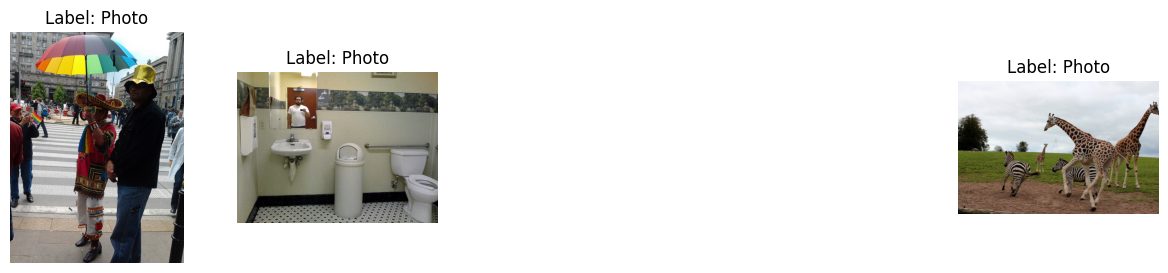

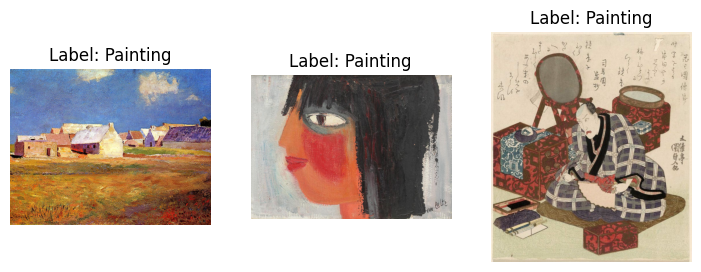

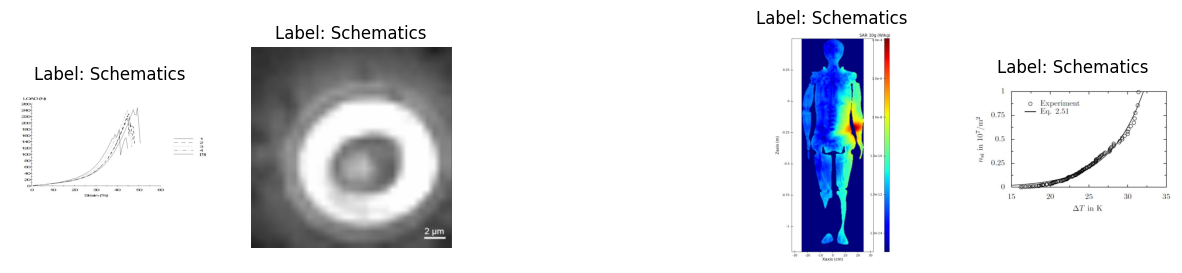

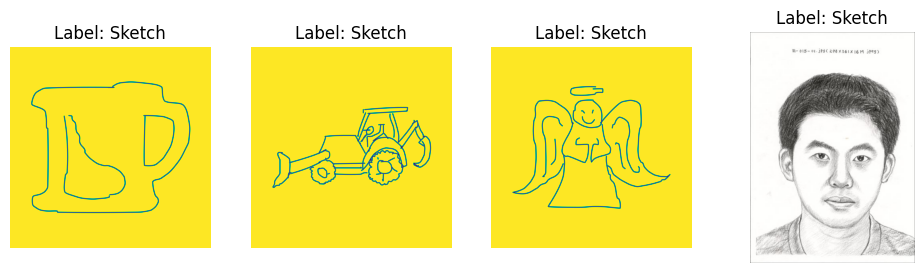

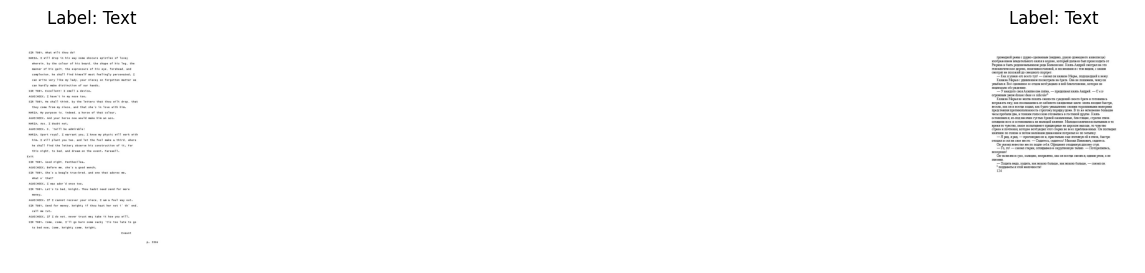

In [ ]:
display_random_images(df)

## 2. Analyse des données

Dans cette partie, nous parcourons un DataFrame contenant des chemins d'images et des libellés afin d'effectue différentes opérations.
Nous conservons les niveaux de couleur, les largeurs et les hauteurs des images puis les valeurs de pixels pour chaque canal de couleur (Rouge, Vert, Bleu).
La boucle principale parcourt chaque image du DataFrame, ouvre l'image, extrait les informations nécessaires puis ferme l'image.
Cela nous permet d'obtenir des informations essentielles sur les images avant de les utiliser pour l'entraînement de notre modèle.

In [ ]:
def get_dataframe_statistics(df: pd.DataFrame):
    # Dictionnaire pour conserver un décompte des modes d'image
    modes_count = {}
    
    # Listes pour conserver les largeurs et les hauteurs des images
    sizes_by_label = {label: {'widths': [], 'heights': []} for label in df['label'].unique()}
    
    # Créez un dictionnaire pour stocker les valeurs de pixels pour chaque label
    pixels_by_label = {label: {'R': {}, 'G':{}, 'B': {}} for label in df['label'].unique()}
    
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Getting values from images"):
        image_path, label = row['image_path'], row['label']
        
        # Essayez d'ouvrir le fichier comme une image
        try:
            with Image.open(image_path) as img:
                # Analyse les modes des images
                mode = img.mode
                modes_count[mode] = modes_count.get(mode, 0) + 1
                
                # Analyse les tailles des images
                w, h = img.size
                sizes_by_label[label]['widths'].append(w)
                sizes_by_label[label]['heights'].append(h)
                
                # Renvoie les valeurs de pixel d'une image en RGB.
                rgb = img.convert("RGB")
                rgb = np.array(rgb)
                for color, index in {'R': 0, 'G': 1, 'B': 2}.items():
                    colorscale = rgb[:,:,index].flatten()
                    pixel_value, value_count = np.unique(colorscale, return_counts=1)
                    for i in range(len(pixel_value)):
                        pixels_by_label[label][color][pixel_value[i]] = pixels_by_label[label][color].get(pixel_value[i], 0) + value_count[i]
        except Exception as e:
            print(f"Couldn't process image {image_path} due to {e}")
            
    return (modes_count, sizes_by_label, pixels_by_label)

In [ ]:
df_modes_count, df_sizes_by_label, df_pixels_by_label = get_dataframe_statistics(df)

Getting values from images:   0%|          | 0/41399 [00:00<?, ?it/s]

### 2.1. Répartition des valeurs de Pixels par label
L'étude de la répartition des valeurs des pixels des images de chaque catégories nous permet de mieux comprendre notre jeu de données.   
Analyser la distribution des valeurs des pixels peut révéler des caractéristiques intrinsèques des images de chaque catégorie.   

In [ ]:
def plot_pixel_distribution(pixels_by_label):    

    # Créez un histogramme pour les canaux de couleur (Rouge, Vert, Bleu) avec des portions de 20 unités
    bin_width = 20
    bins = range(0, 256, bin_width)
    if bins[-1] > 255:
        bins = bins[:-1]
    labels = [f"{pixel_step}-{min(pixel_step + bin_width, 255)}" for pixel_step in bins]

    # Créez un sous-traceur pour chaque label et chaque canal de couleur
    fig, axs = plt.subplots(len(pixels_by_label), 3, figsize=(15, 6 * len(pixels_by_label)), sharex=False)

    # Parcourez les labels et tracez les histogrammes pour chaque canal de couleur
    for i, (label, pixel_counts) in enumerate(pixels_by_label.items()):
        r_counts = [sum([pixel_counts['R'].get(pixel, 0) for pixel in range(pixel_step, min(pixel_step + bin_width, 256))]) for pixel_step in bins]
        g_counts = [sum([pixel_counts['G'].get(pixel, 0) for pixel in range(pixel_step, min(pixel_step + bin_width, 256))]) for pixel_step in bins]
        b_counts = [sum([pixel_counts['B'].get(pixel, 0) for pixel in range(pixel_step, min(pixel_step + bin_width, 256))]) for pixel_step in bins]

        ax_r = axs[i][0]
        ax_g = axs[i][1]
        ax_b = axs[i][2]

        ax_r.bar(bins, r_counts, width=bin_width, color='red', alpha=0.7)
        ax_g.bar(bins, g_counts, width=bin_width, color='green', alpha=0.7)
        ax_b.bar(bins, b_counts, width=bin_width, color='blue', alpha=0.7)

        ax_r.set_title(f'Label {label} - Rouge')
        ax_g.set_title(f'Label {label} - Vert')
        ax_b.set_title(f'Label {label} - Bleu')

        ax_r.set_xlabel('Valeur de pixel')
        ax_g.set_xlabel('Valeur de pixel')
        ax_b.set_xlabel('Valeur de pixel')
        
        ax_r.set_xticks(bins, rotation=45, labels=labels)
        ax_g.set_xticks(bins, rotation=45, labels=labels)
        ax_b.set_xticks(bins, rotation=45, labels=labels)
        
        ax_r.set_ylabel('Nombre de pixels')
        ax_g.set_ylabel('Nombre de pixels')
        ax_b.set_ylabel('Nombre de pixels')

    plt.tight_layout()
    plt.show()

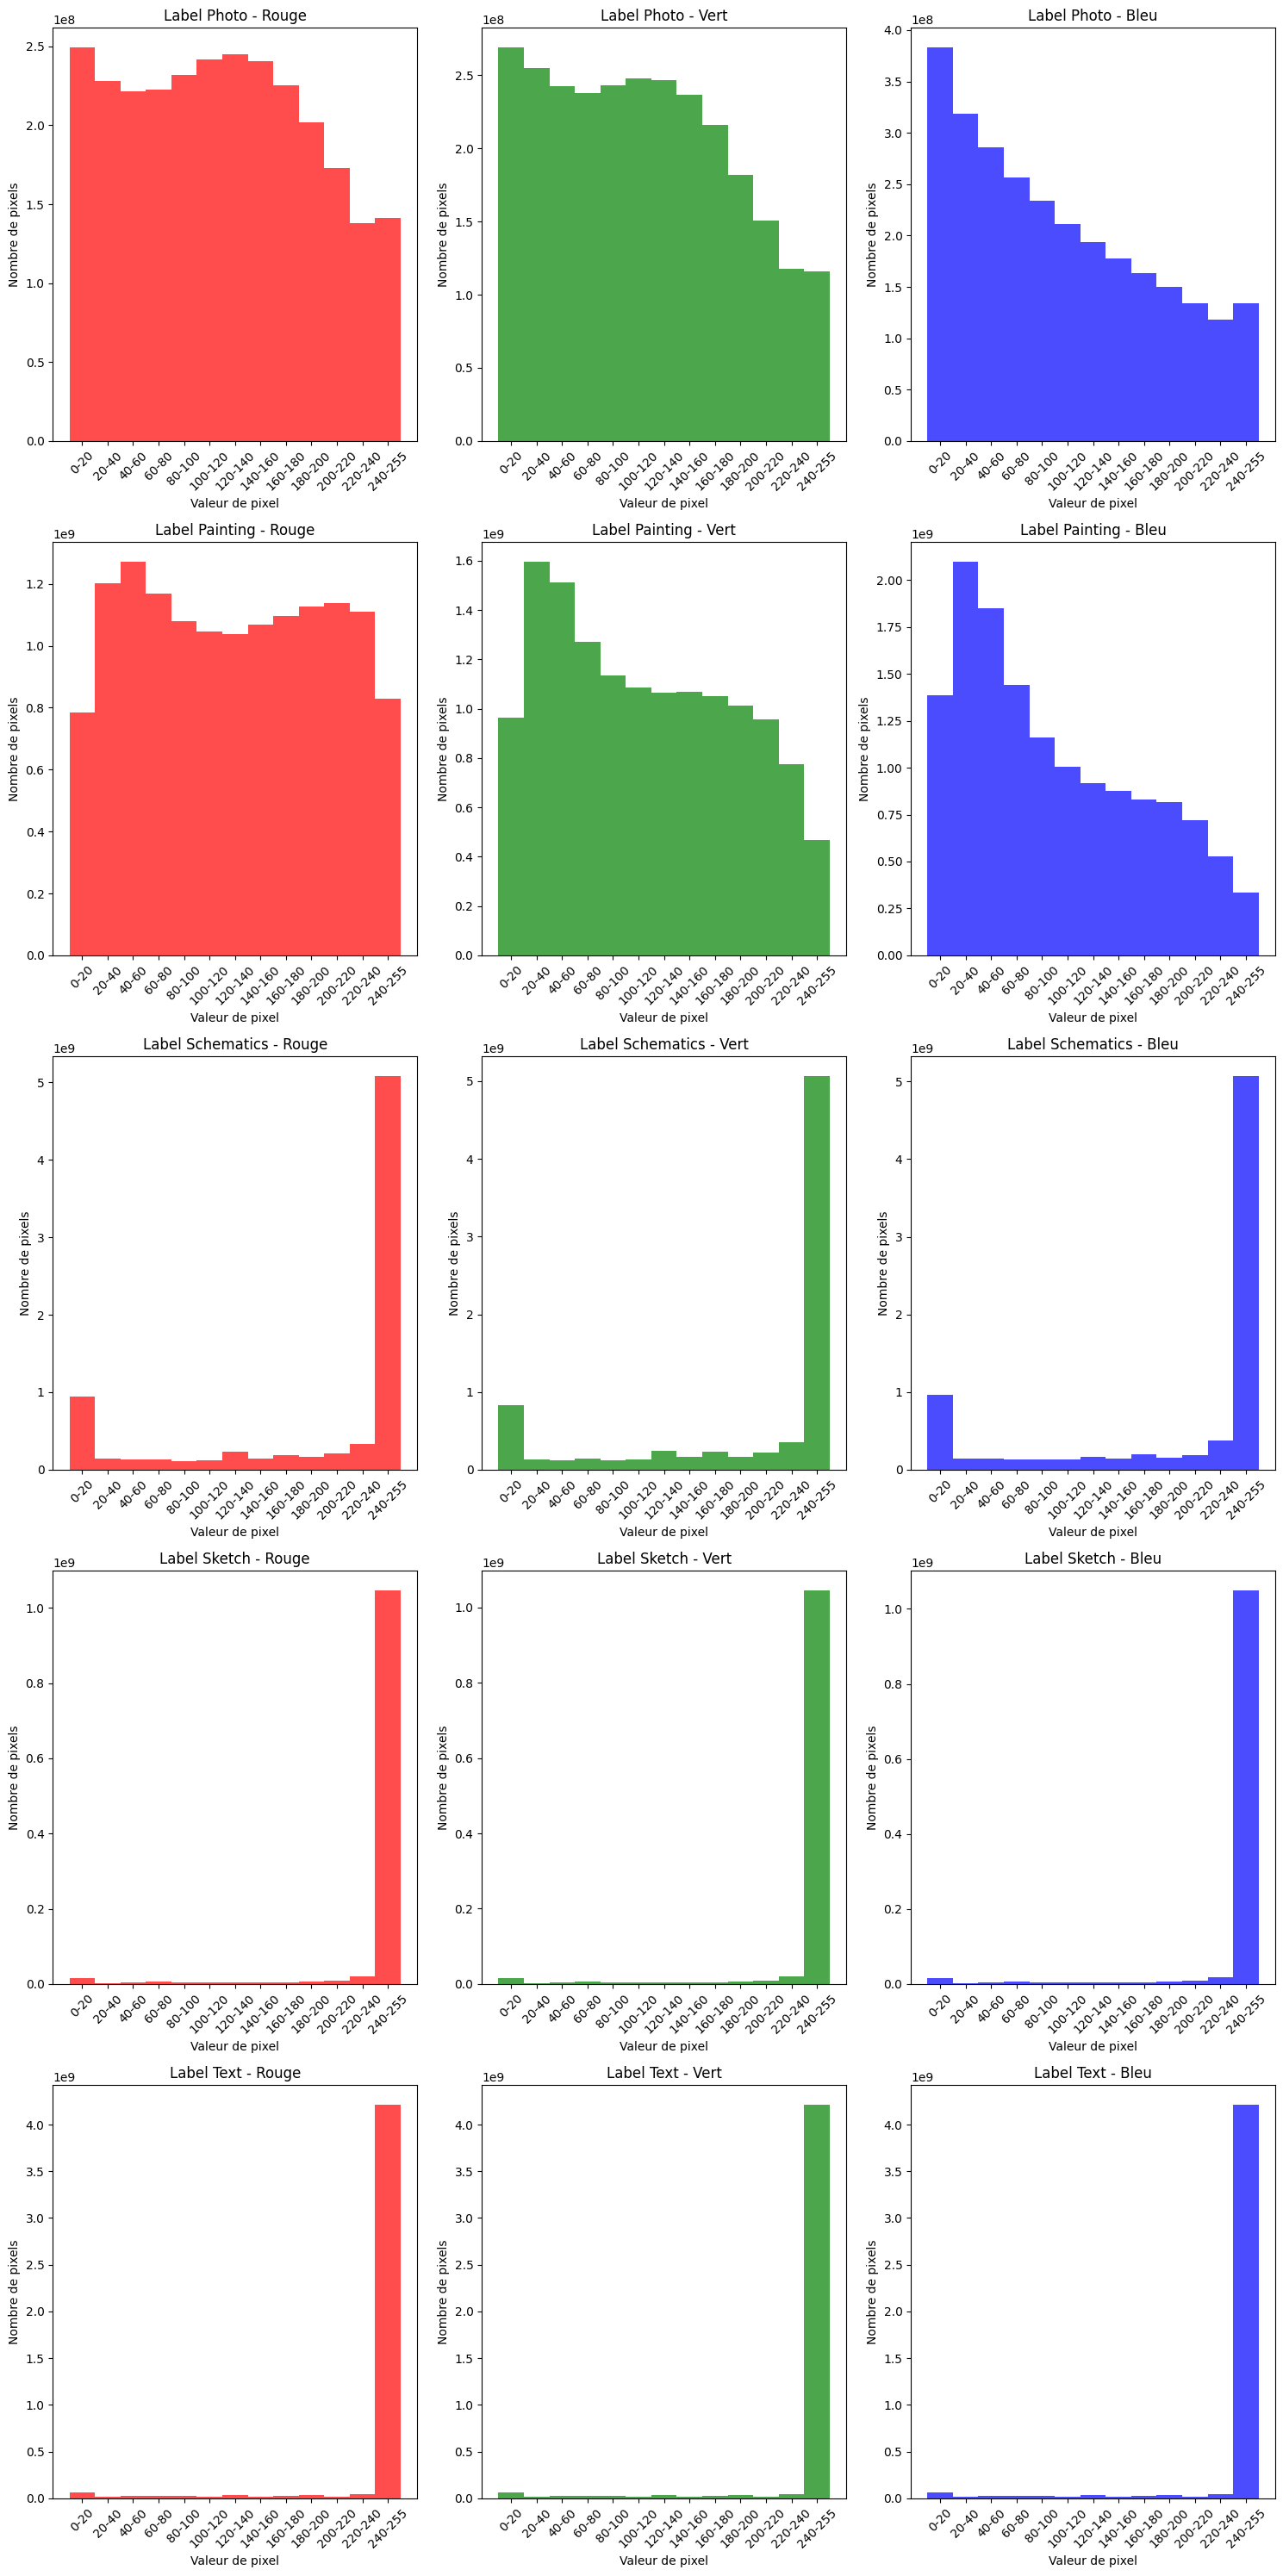

In [ ]:
plot_pixel_distribution(df_pixels_by_label)

Par exemple, on peut voir ici que les textes, les schémas et les dessins sont essentiellement composés de pixels noirs et blancs. Cette information peut expliquer que le modèle écarte facilement les images qui appartiennent à ces catégories car les photos sont généralement en couleur. En revanche, des photos en noir et blanc pourraient être écartées car confondues avec ces catégories.   
On observe aussi que la distribution des pixels entre les photos et les peintures est très similaire et pourrait amener le modèle à se tromper.

### 2.2. Types de couleurs
Afin d'assurer la cohérence de nos données, il est important que toutes les images soient encodées selon le même type de couleur. Cela assurera que le modèle évalue chaque donnée de la même manière.

In [ ]:
def analyze_image_modes(modes_count):
    """Analyse les modes des images depuis un dataframe, affiche leur distribution, 
    et imprime le décompte précis pour chaque mode."""
    
    # Afficher la distribution des modes d'image
    modes = list(modes_count.keys())
    counts = list(modes_count.values())
    
    plt.bar(modes, counts, color='skyblue')
    plt.yscale('log')
    plt.xlabel('Mode d\'image')
    plt.ylabel('Nombre d\'images')
    plt.title('Répartition des modes d\'image')
    plt.show()
    
    # Afficher le nombre précis pour chaque mode
    for mode, count in modes_count.items():
        print(f"Mode {mode}: {count} images")

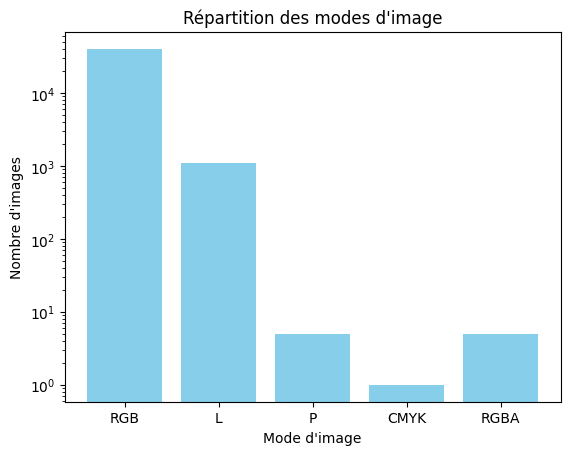

Mode RGB: 40297 images
Mode L: 1091 images
Mode P: 5 images
Mode CMYK: 1 images
Mode RGBA: 5 images


In [ ]:
analyze_image_modes(df_modes_count)

On peut voir ici que la majorité des images ont au format RGB. Cependant il a aussi d'autres formats. Il sera donc nécéssaire de transformer toutes les images au format RGB.

### 2.3. Taille des images

On utilise l'échelle logarithmique pour rendre la visualisation des données plus informative, en particulier lorsque les données ont une grande plage de valeurs et que l'on souhaite examiner les variations dans les valeurs plus petites en détail.

In [ ]:
def analyze_image_sizes(sizes_by_label):
    """Analyse les tailles des images depuis un dataframe et affiche leur distribution à l'échelle logarithmique."""
    
    n_labels = len(sizes_by_label)
    
    fig, axes = plt.subplots(n_labels, 1, figsize=(10, 6 * n_labels))
    
    if n_labels == 1:
        axes = [axes]
    
    for ax, (label, sizes) in zip(axes, sizes_by_label.items()):
        ax.scatter(sizes['widths'], sizes['heights'], alpha=0.3, marker=".")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Largeur de l\'image (log)')
        ax.set_ylabel('Hauteur de l\'image (log)')
        ax.set_title(f'Répartition des tailles d\'image pour {label} (échelle logarithmique)')
        ax.grid(True, which="both", ls="--", c='0.7')
    
    plt.tight_layout()
    plt.show()

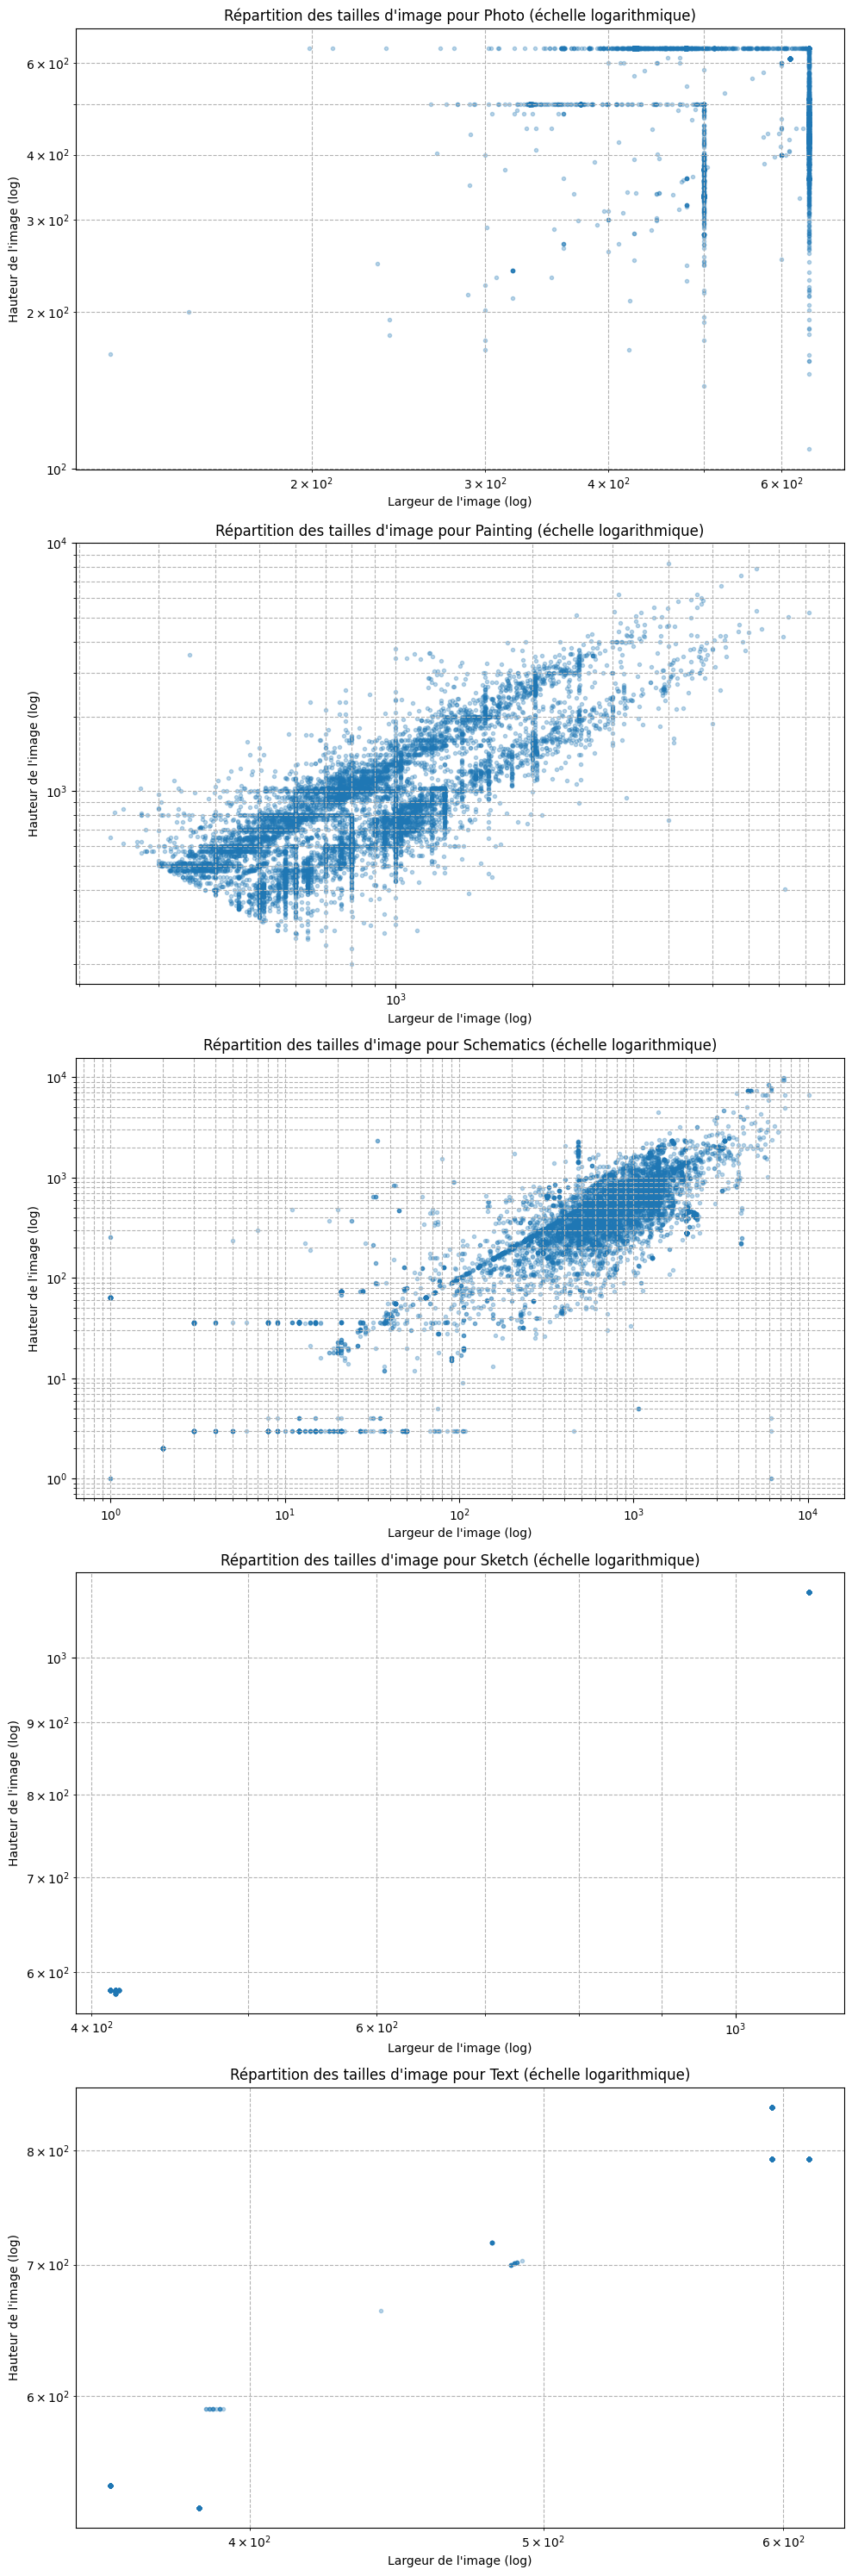

In [ ]:
analyze_image_sizes(df_sizes_by_label)

Certaines images ont des tailles abérantes. Cependant, les tailles des photos sont plutôt homogènes et ne dépassent pas 650 par 650. Si des photos avaient des tailles abérantes, il faudrait les supprimer du jeu d'entraînement afin d'éviter de biaiser le modèle en prenant en compte des abérations. Cependant, comme les images abérantes ne sont pas des photos, on les garde afin que le modèle comprenne que les images aux tailles abérantes ne sont généralement pas des photos.

### 2.4. Ratio des images

Le ratio d'image est une caractéristique importante dans l'analyse des données, car nous avons des informations sur la forme et la structure des images, ce qui est pertinent dans notre cas. Il permet également de voir les ratios trop abhérent.

In [ ]:
def get_image_ratios(sizes_by_label):
    """Retourne les ratios des images par label depuis un dataframe."""
    ratios_by_label = {}
    for label, sizes in sizes_by_label.items():
        widths = sizes['widths']
        heights = sizes['heights']
        ratios = np.array([np.array(widths) / np.array(heights), np.array(heights) / np.array(widths)]).max(axis=0)
        ratios_by_label[label] = ratios
    return ratios_by_label

In [ ]:
def analyze_image_ratios(ratios_by_label):
    """Analyse les ratios des images depuis un dataframe et affiche leur distribution."""
    
    n_labels = len(ratios_by_label)
    
    # Créer une grille de sous-graphiques
    fig, axes = plt.subplots(n_labels, 1, figsize=(10, 10))
    
    # Si vous avez seulement un label, axes n'est pas une liste, donc on le convertit en liste pour la boucle
    if n_labels == 1:
        axes = [axes]
    
    for ax, (label, ratios) in zip(axes, ratios_by_label.items()):
        ax.boxplot(ratios, vert=False)
        ax.set_xscale('log')
        ax.set_xlabel('Ratio (Largeur / Hauteur) ou (Hauteur / Largeur)')
        ax.set_title(f'Distribution des ratios d\'image pour {label}')
        ax.grid(True, which="both", ls="--", c='0.7')
    
    plt.tight_layout()
    plt.show()


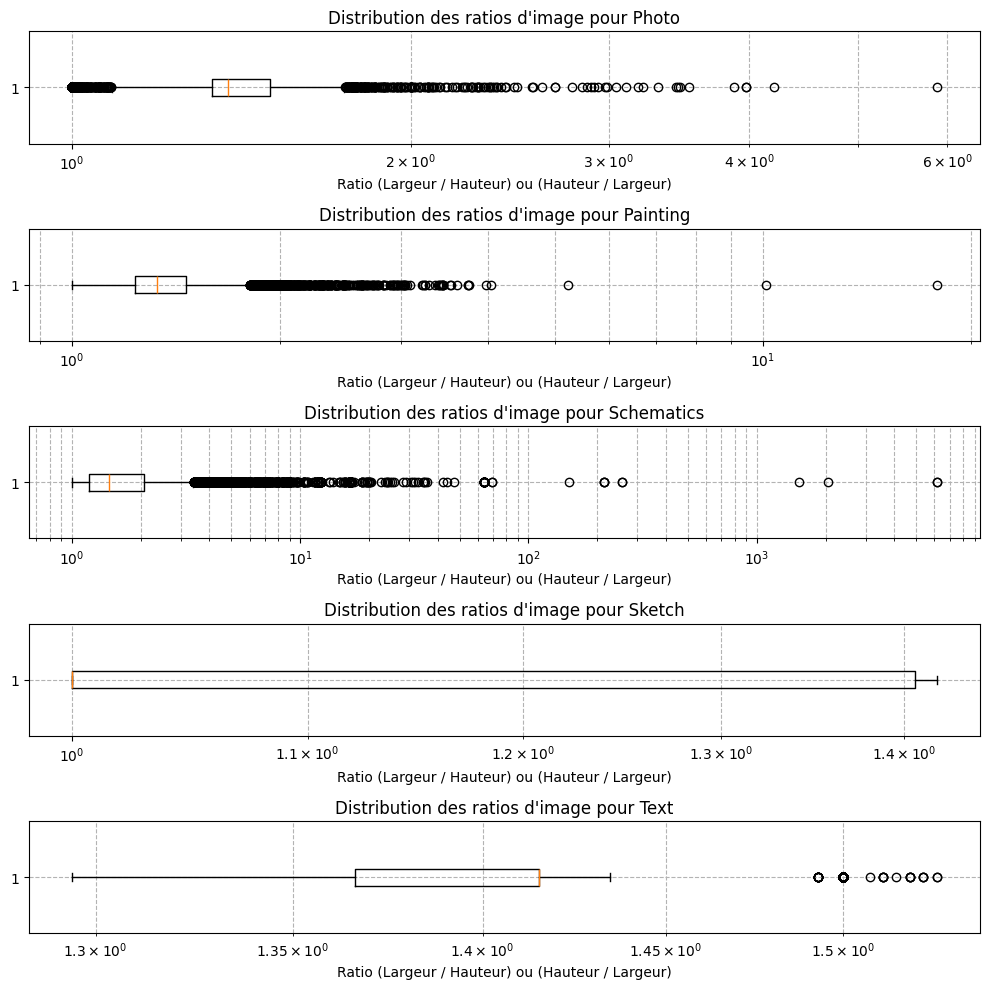

In [ ]:
df_ratios = get_image_ratios(df_sizes_by_label)
analyze_image_ratios(df_ratios)

Certaines images ont des ratios abérants. Cependant, les ratios des photos ne dépassent pas 6. Si des photos avaient des ratios abérants, il faudrait les supprimer du jeu d'entraînement afin d'éviter de biaiser le modèle en prenant en compte des abérations. Cependant, comme les images abérantes ne sont pas des photos, on les garde afin que le modèle comprenne que les images aux ratios abérants ne sont généralement pas des photos.

### 2.5. Répartition des classes

In [ ]:
def class_distribution(df):
    """
    Plots the distribution of classes (labels) in the given DataFrame.

    Parameters:
    - df: DataFrame containing the labels.

    Returns:
    - None
    """
    label_counts = df['label'].value_counts()

    plt.figure(figsize=(10,6))
    label_counts.plot(kind='bar')
    plt.title('Répartition des labels')
    plt.xlabel('Labels')
    plt.ylabel('Nombre d\'images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

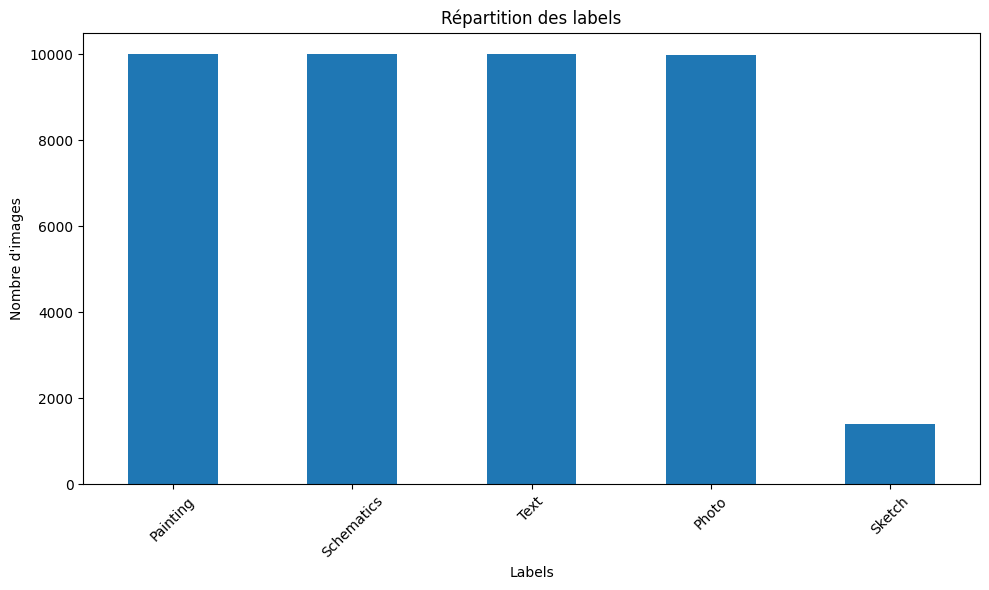

In [ ]:
class_distribution(df)

On peut voir ici que la répartition des classes est homogène à part pour les Sketch. Ce n'est pas si grave car les sketch sont de nature très différentes des images (couleurs, tailles et ratios) donc le modèle pourra facilement les classifier en tant que "non-photo". Cependant étant donné que notre classifieur est binaire, il faudra regrouper toutes les images qui ne sont pas des photos sous le nom "not-photo". Dans ce cas il y aura beaucoup plus de non photos que de photos, ce qui pose problème pour l'entraînement du modèle. En effet, si il y a trop peu de photos par rapport au non-photos, le modèle pourra prédire non-photo à chaque fois et être preformant, ce qui le biaisera.

## 3. Nettoyage des données

Le nettoyage des données nous permet d'identifier et de corriger les erreurs, les incohérences, les valeurs aberrantes, les données manquantes et d'autres problèmes dans un jeu de données brut. Le nettoyage des données permet plusieurs choses importantes comme améliorer la qualité des données, optimiser les performances du modèle ou encore renforcer la confiance dans les résultats.

Ainsi, nous garantissons que les données utilisées dans l'analyse et l'apprentissage sont fiables, précises et de haute qualité, ce qui contribue à un modèles plus performants.

### 3.1. Augmentation des données

Pour remédier au problème identifié lors de la répartion des classes, nous allons augmenter nos photos, c'est à dire créer de nouvelles données à partir de ces dernières. Ceci nous permettra d'obtenir un jeu de données qui contient environ autant de photos que de non-photos ce qui permettra au modèle de s'entraîner efficacement.

In [ ]:
def augment_images(directory_path):
    for img_path in Path(directory_path).glob('aug_*'):
        os.remove(img_path)
    
    for file_name in tqdm(os.listdir(directory_path), desc="File"):    
        file_path = os.path.join(directory_path, file_name)    
        try:
            # Lire l'image avec TensorFlow
            image = tf.io.read_file(file_path)
            image = tf.image.decode_image(image, channels=3)
            img_height, img_width, _ = image.shape
            
            image = image.numpy().reshape((1,image.shape[0],image.shape[1],3))

            # Calculate the diagonal of the image
            diagonal = math.sqrt(pow(img_width, 2) + pow(img_height, 2))
            
            # Calculate the scale factor
            scale_factor = (min(img_width, img_height) / diagonal) - 0.1

            img_gen = ImageDataGenerator(
                rotation_range=45,
                zoom_range=[scale_factor - 0.2, scale_factor],
                horizontal_flip=True,
                fill_mode='wrap',
                validation_split=0
            ).flow(image, save_to_dir=directory_path, save_prefix='aug_' + os.path.basename(file_name).split('.')[0], save_format='jpeg')

            # Créer des augmentations pour une image et les enregistrer
            for batch in range(2):
                next(img_gen)

            
        except Exception as e:
            print(f"Erreur lors du traitement de l'image {file_path}: {e}")

In [ ]:
augment_images(os.path.join(sources_directory, "Photo"))

File:   0%|          | 0/9993 [00:00<?, ?it/s]

### 3.2. Nettoyage et enregistrement des données nettoyées
Afin de rendre les données cohérentes pour notre modèle il convient de corriger les diparités étudiées précédemment.  
Pour cela, nous allons appliquer différentes opérations à nos images avant de les enregistrer dans processed-data.  
- Conversion des images en RGB
- Redimensionnement des images
- Vérification que les fichiers sont lisibles par tensorflow  
  
La normalisation des images est essentielle pour optimiser les performances de notre CNN. Cependant, nous différerons cette étape pour permettre l'enregistrement au format JPEG et garantir la compatibilité avec nos analyses précédentes, assurant ainsi la vérification correcte du traitement des données.


In [3]:
def process_images(source_directory, destination_directory, target_size, valid_extensions):
    if os.path.exists(destination_directory):
        shutil.rmtree(destination_directory)
    
    # Créer le dossier de destination s'il n'existe pas
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    for folder_name in tqdm(os.listdir(source_directory), desc="Directory", position=0):
        source_folder_path = os.path.join(source_directory, folder_name)
        if folder_name == "Photo":
            dest_folder_name = "photos"
        else:
            dest_folder_name = "not-photos"
            
        destination_folder_path = os.path.join(destination_directory, dest_folder_name)
        
        # Créer le sous-dossier dans le dossier de destination s'il n'existe pas
        if not os.path.exists(destination_folder_path):
            os.makedirs(destination_folder_path)
        
        for file_name in tqdm(os.listdir(source_folder_path), desc="File", position=1, leave=False):
            if any(file_name.endswith(extension) for extension in valid_extensions):
                source_file_path = os.path.join(source_folder_path, file_name)
                transient_file_path = os.path.join(destination_folder_path, "transient_" + file_name)
                destination_file_path = os.path.join(destination_folder_path, file_name)
                try:
                    # Convertir l'image en RGB et redimensionner avec PIL
                    with Image.open(source_file_path) as img:
                        img_rgb = img.convert('RGB')
                        img_resized = img_rgb.resize(target_size)
                        img_resized.save(transient_file_path, "JPEG")
                    
                    # Lire et vérifier l'image avec TensorFlow
                    image = tf.io.read_file(transient_file_path)
                    image = tf.image.decode_image(image)
                    
                    # Normaliser l'image
                    #image = tf.image.convert_image_dtype(image, tf.float32, saturate=True)
                    
                    # Enregistrer l'image traitée
                    encoded_image = tf.image.encode_jpeg(tf.image.convert_image_dtype(image, dtype=tf.uint8, saturate=True))
                    tf.io.write_file(destination_file_path, encoded_image)
                    
                except Exception as e:
                    print(f"Erreur lors du traitement de l'image {source_file_path}: {e}")
                
                if os.path.exists(transient_file_path):
                    os.remove(transient_file_path)

    print("Traitement terminé!")

In [4]:
process_images(sources_directory, process_directory, image_target_size, image_valid_extensions)

Directory:   0%|          | 0/6 [00:00<?, ?it/s]

File:   0%|          | 0/1 [00:00<?, ?it/s]

File:   0%|          | 0/10000 [00:00<?, ?it/s]

File:   0%|          | 0/29979 [00:00<?, ?it/s]

File:   0%|          | 0/10001 [00:00<?, ?it/s]

File:   0%|          | 0/1406 [00:00<?, ?it/s]

File:   0%|          | 0/10000 [00:00<?, ?it/s]

Traitement terminé!


### 3.3. Vérification des données

Dans cette partie, nous faisons le même traitement que la partie "Analyse des données" à la différence que nous l'effectuons sur les données transformées contenant les images d'origines et les images augmentées.   
Ceci nous permet de valider l'éfficacité de notre pré-traitement.

In [ ]:
cleanned_df = load_dataframe(process_directory, categories=["photos", "not-photos"])
cleanned_df.head()

#### Visualisation des photos

Nous avons donc un aperçu des données transformées. Certaines images ont donc subbies une rotation ainsi qu'un zoom.   
Toutes les images sont au format 150 par 150

In [ ]:
display_random_images(cleanned_df)

In [ ]:
cleanned_modes_count, cleanned_sizes_by_label, cleanned_pixels_by_label = get_dataframe_statistics(cleanned_df)

#### Répartition des couleurs par image

Nous vérifions ici que toutes nos images soient dans le même mode de couleur (ici RGB) afin que d'autres ne viennent pas fausser nos résultats.

In [ ]:
analyze_image_modes(cleanned_modes_count)

In [ ]:
cleanned_ratios = get_image_ratios(cleanned_sizes_by_label)

#### Taille et ratio

En suivant le traitement fait, il est donc logique que le ratio des images soit désormais regroupé dans un même point puisque nous avons redimmensionné les images à la même taille.

In [ ]:
analyze_image_ratios(cleanned_ratios)

#### Répartition des classes

Après transformation, nous avions environ 10'000 photos pour 30'000 non-photos. C'est donc pour cela que nous avons fait de l'augmentation des données afin de pouvoir équilibrer les deux.

In [ ]:
class_distribution(cleanned_df)

# Conclusion
Nous avons traité nos données et possédons maintenant un jeu de données optimal pour être traîté par un classifieur binaire de type CNN.   
La prochaine étape consiste à créer ce modèle.   
Voir [classification-binaire](./classification-binaire.ipynb) pour la suite.